# <center>Artificial Neural Network Model to Predict Populations Size

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

---
### <center> Generating the Treatment and Defining the Parameters

Define treatments matrix where each array represents a distinct treatment and each value in the array represents dose amount treatment is given on seven sessions every two days a dose is given, we take observations every two hours each observation contains: Cancer type 1, Type 2 and immune Cells population.

In [2]:
Treatment = [[0, 0, 0, 0, 0, 0, 0],
             [1e-9, 1e-9, 1e-9, 1e-9, 1e-9, 1e-9, 1e-9],
             [1e-7, 1e-7, 1e-7, 1e-7, 1e-7, 1e-7, 1e-7],
             [1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
             [1e-9, 1e-5, 1e-9, 1e-5, 1e-9, 1e-5, 1e-9],
             [0, 1e-5, 0, 1e-5, 0, 1e-5, 0]]
# we take observations every two hours each observation contains: Cancer type 1, Type 2 and immune Cells population
observations_horizon = 24  # n number of observations for each value of single treatment
treatment_full = [[c[T] for T in range(len(c)) for k in range(observations_horizon)] for c in Treatment]
x0 = [60.4551985, 56.1345208, 46.32307756]
t = np.linspace(1, len(treatment_full[0]), len(treatment_full[0]))  # time array
num_plots = len(Treatment) # Set the number of plots to be generated
num_cols = 2  # Set the number of columns for subplots (can be adjusted as needed)
num_rows = int(np.ceil(num_plots / num_cols))

---
## <center>Generate Data from Lotka-Volterra Model

### Generate Lotka-Volterra Data
We generate synthetic data using the dynamical model: Lotka-Voltera with specific parameters 

In [3]:
def discrete_lotka_volterra(x0, treatment, params):
    ''' 
    This function is to simulate the discrete Lotka-Volterra model with treatment
    x0: initial values of the populations
    treatment: the treatment for each time step
    params: parameters of the model
    show_plot: whether to show the plot of the simulation
    return: the populations of each type of cells
    '''
    r1, r2, r3, d12, d13, d21, d23, d31, d32, K, c1, c2, c3, m12, m13, m2, m3 = params # Parameters of the model
    i0, x10, x20 = x0 
    i1p, x1p, x2p = [], [], []
    for i in treatment:
        i_curr, x1_curr, x2_curr = i0, x10, x20    
        i11p, x11p, x22p = [], [], []
        for k in range(len(i)):
            x = x1_curr + x2_curr + i_curr
            f1 = i_curr / x  # frequency of immune cells
            f2 = x1_curr / x # frequency of cancer cells of type 1
            f3 = x2_curr / x # frequency of cancer cells of type 2
            di11 = i_curr * (r1 * f1 + d12 * f2 + d13 * f3) * (1 - x/K) - (c1 + c1 * 10**5 * i[k]) * i_curr - (m12 + m13) * i_curr
            dx11 = x1_curr * (d21 * f1 + r2 * f2 + d23 * f3) * (1 - x/K) - (c2 + c2 * 10**5 * i[k]) * x1_curr - m2 * x1_curr + m12 * i_curr + m3 * x2_curr
            dx22 = x2_curr * (d31 * f1 + d32 * f2 + r3 * f3) * (1 - x/K) - (c3 + c3 * 10**5 * i[k]) * x2_curr - m3 * x2_curr + m13 * i_curr + m2 * x1_curr
            i11p.append(i_curr), x11p.append(x1_curr), x22p.append(x2_curr)
            i_curr += di11
            x1_curr += dx11
            x2_curr += dx22
        i1p.append(i11p), x1p.append(x11p), x2p.append(x22p) # append the data for each treatment
    return i1p, x1p, x2p

### Example:

In [4]:
param_lotka_volterra = [0.3, 0.4, 0.2, 0, 0, 0, 0, 0, 0, 300, 0.04, 0.05, 0.05, 0.005, 0.005, 0.01, 0.01]
i, x1, x2 = np.array(discrete_lotka_volterra(x0, treatment_full, param_lotka_volterra))

### Build Data Frame

In [5]:
I = 0 # treatment number
data = pd.DataFrame({'Time': np.arange(0, 168, 1), 'Dose': treatment_full[I], 'Immune': i[I], 'U87': x1[I], 'U251': x2[I]})
data.tail()

,Time,Dose,Immune,U87,U251
163,163,0,0.084647,209.929733,38.355301
164,164,0,0.080416,209.932909,38.357579
165,165,0,0.076397,209.935915,38.359750
166,166,0,0.072578,209.938762,38.361818
167,167,0,0.068950,209.941457,38.363788


### Create the model

In [6]:
input_shape = (5,)
# add stopping criteria
stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
model = Sequential()
model.add(Dense(82, input_shape=input_shape, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softplus'))
model.add(Dense(3, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 82)                492       
                                                                 
 dropout (Dropout)           (None, 82)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 664       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 1183 (4.62 KB)
Trainable params: 1183 (4.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


6/6 [==============================] - 0s 1ms/step


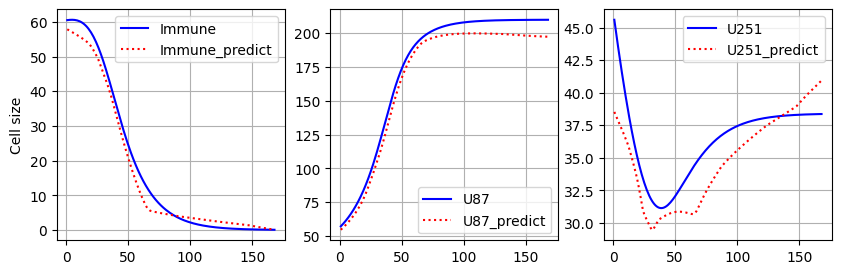

6/6 [==============================] - 0s 1ms/step


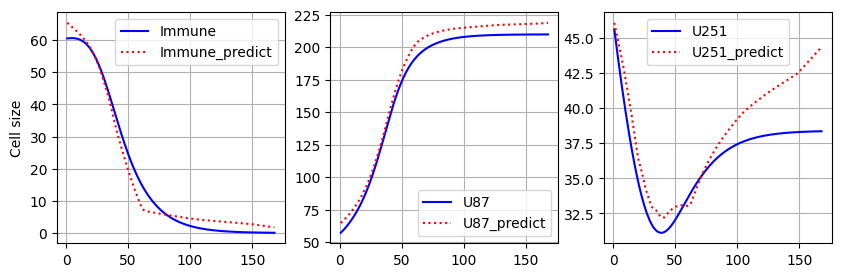

6/6 [==============================] - 0s 1ms/step


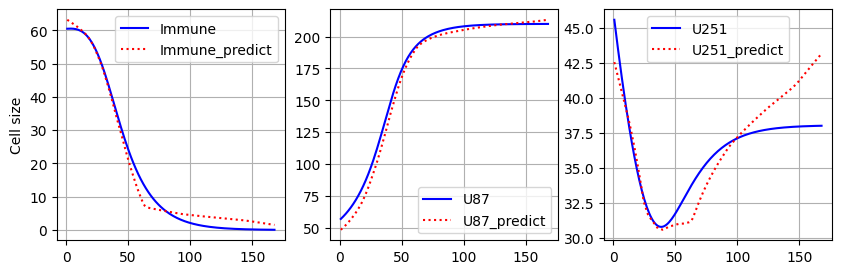

In [7]:
for I in range(len(Treatment)-3):
    data = pd.DataFrame({'Time': np.arange(0, 168, 1), 'Dose': treatment_full[I], 'Immune': i[I], 'U87': x1[I], 'U251': x2[I]})
    X = data.iloc[0:167,:]
    Y = data.iloc[1:168, 2:5]
    model.fit(X, Y, epochs=500, batch_size=1, verbose=0, validation_split=0.25, callbacks=[stopper])    
    # predict the next 24 hours
    prediction = model.predict(X.iloc[166].values.reshape(1, -1))
    t = np.linspace(1, 168, 167)
    immune = list(Y.iloc[:, 0])
    U87 = list(Y.iloc[:, 1])
    U251 = list(Y.iloc[:, 2])
    immune_predict = [i[0] for i in model.predict(X)]
    U87_predict = [i[1] for i in model.predict(X)]
    U251_predict = [i[2] for i in model.predict(X)]
    
    # plot the results
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.plot(t, immune, 'b-', label='Immune')
    plt.plot(t, immune_predict, 'r:', label='Immune_predict')
    plt.ylabel('Cell size')
    plt.grid()
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(t, U87, 'b-', label='U87')
    plt.plot(t, U87_predict, 'r:', label='U87_predict')
    plt.grid()
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(t, U251, 'b-', label='U251')
    plt.plot(t, U251_predict, 'r:', label='U251_predict')
    plt.legend()
    plt.grid()
    plt.show()

### Define the Prediction Values for the Test Data and Plot them

6/6 [==============================] - 0s 2ms/step


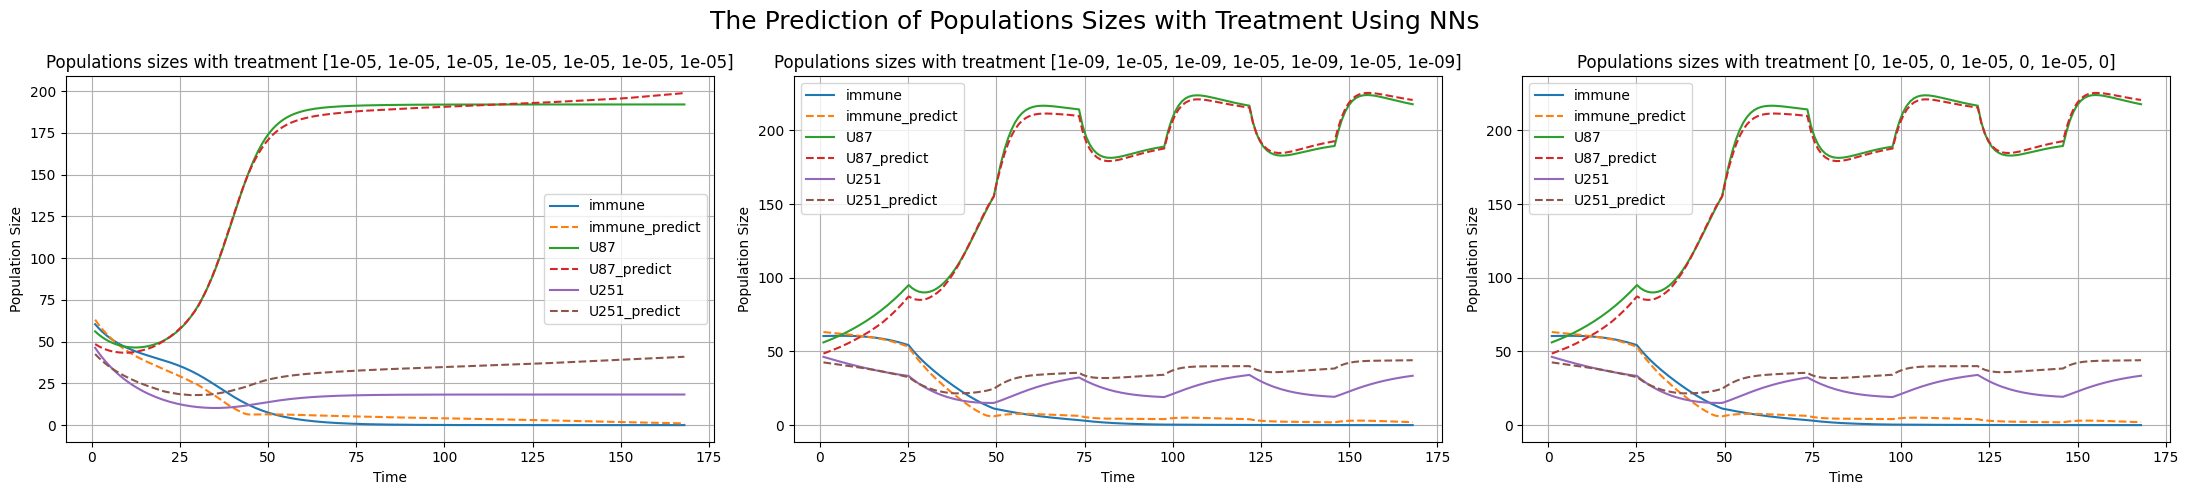

In [9]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(22, 5))  # 1 row, 3 columns of subplots

for idx, I in enumerate([3, 4, 5]):
    data = pd.DataFrame({'Time': np.arange(0, 168, 1), 'Dose': treatment_full[I], 'Immune': i[I], 'U87': x1[I], 'U251': x2[I]})
    X = data.iloc[0:167,:]
    Y = data.iloc[1:168, 2:5]
    t = np.linspace(1, 168, 167)
    immune = list(X.iloc[:, 2])
    U87 = list(X.iloc[:, 3])
    U251 = list(X.iloc[:, 4])
    immune_predict = [i[0] for i in model.predict(X)]
    U87_predict = [i[1] for i in model.predict(X)]
    U251_predict = [i[2] for i in model.predict(X)]

    # Access the appropriate subplot
    ax = axes[idx]
    
    for k, label in zip([immune, immune_predict, U87, U87_predict, U251, U251_predict], ['immune', 'immune_predict', 'U87', 'U87_predict', 'U251', 'U251_predict']):
        if k == immune or k == U87 or k == U251:
            ax.plot(t, k, '-', label=label)
        else:
            ax.plot(t, k, '--', label=label)
    ax.set_xlabel('Time')
    ax.set_ylabel('Population Size')
    ax.set_title(f'Populations sizes with treatment {Treatment[I]}')
    ax.legend()
    ax.grid()

# now add overall title
fig.suptitle('The Prediction of Populations Sizes with Treatment Using NNs', fontsize=18)
plt.tight_layout()
plt.show()

### Try to Generate the input data from the output one

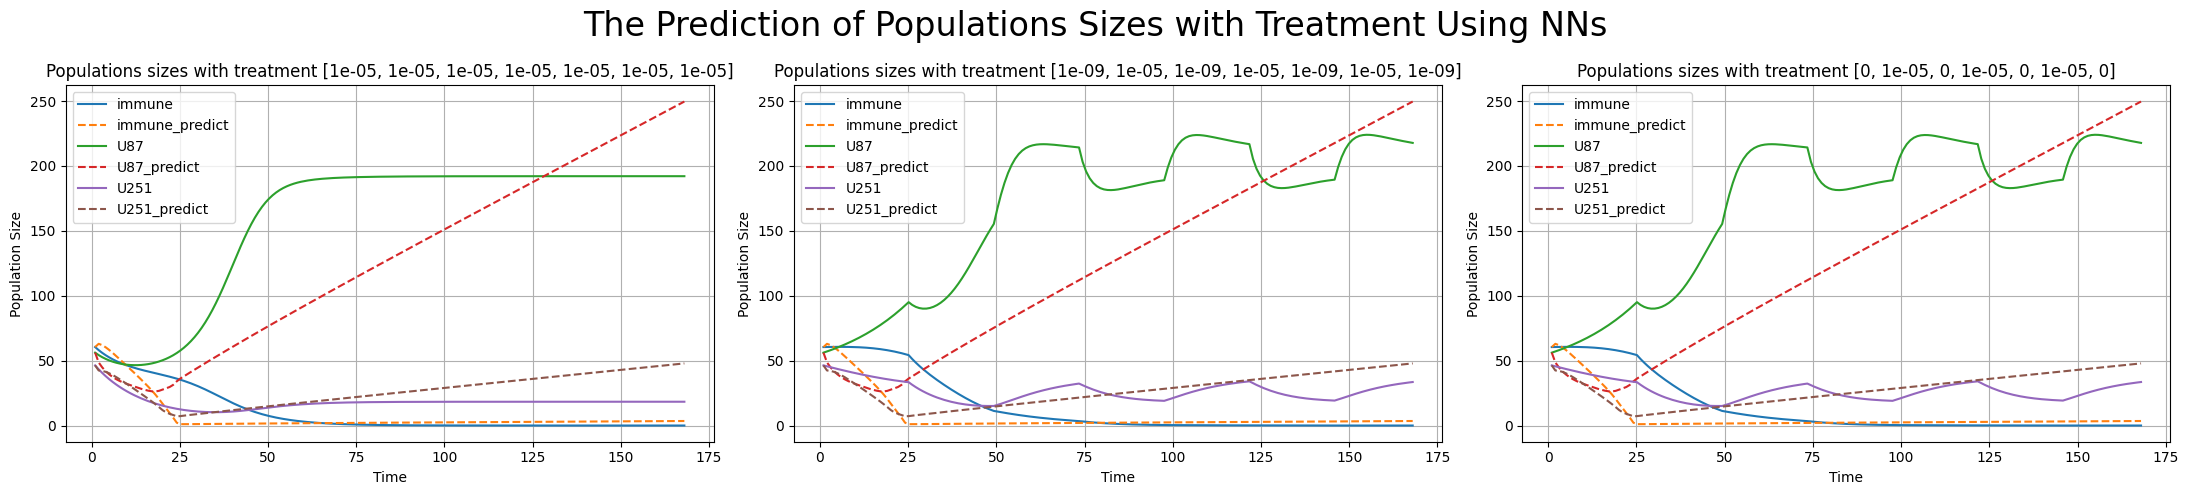

In [10]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(22, 5))  # 1 row, 3 columns of subplots

for idx, I in enumerate([3, 4, 5]):
    data = pd.DataFrame({'Time': np.arange(0, 168, 1), 'Dose': treatment_full[I], 'Immune': i[I], 'U87': x1[I], 'U251': x2[I]})
    X = data.iloc[0:167,:]
    Y = data.iloc[1:168, 2:5]
    t = np.linspace(1, 168, 167)
    x = np.array([60.4551985, 56.1345208, 46.32307756])
    pred = [x]
    for k in range(len(t)-1):
        x = model.predict(np.concatenate((np.array([t[k], treatment_full[I][k]]), x), axis=0).reshape(1, -1), verbose=0)
        x = x[0]
        pred.append(x)
    immune = list(X.iloc[:, 2])
    U87 = list(X.iloc[:, 3])
    U251 = list(X.iloc[:, 4])
    immune_predict = [_[0] for _ in pred]
    U87_predict = [_[1] for _ in pred]
    U251_predict = [_[2] for _ in pred]

    # Access the appropriate subplot
    ax = axes[idx]
    
    for k, label in zip([immune, immune_predict, U87, U87_predict, U251, U251_predict], ['immune', 'immune_predict', 'U87', 'U87_predict', 'U251', 'U251_predict']):
        if k == immune or k == U87 or k == U251:
            ax.plot(t, k, '-', label=label)
        else:
            ax.plot(t, k, '--', label=label)
    ax.set_xlabel('Time')
    ax.set_ylabel('Population Size')
    ax.set_title(f'Populations sizes with treatment {Treatment[I]}')
    ax.legend()
    ax.grid()

# now add overall title
fig.suptitle('The Prediction of Populations Sizes with Treatment Using NNs', fontsize=24)
plt.tight_layout()
plt.show()